# Progetto A.A 2020-2021

<strong>Programmazione di Applicazioni Data Intensive</strong><br>
Arcara Alessio <br> alessio.arcara@studio.unibo.it <br> Matricola: 0900061028<br>
<a href="https://www.kaggle.com/aaron7sun/stocknews">Kaggle: Daily News for Stock Market Prediction</a>

## Introduzione

Il dataset scelto è composto da due file *csv* :
1. <strong>News data</strong>: i titoli dei post dal canale Reddit WorldNews (<a href="https://www.reddit.com/r/worldnews/">/r/worldnews</a>). Sono classificate con i voti degli utenti reddit, e solo i 25 migliori titoli sono considerati per singolo giorno. <br>*(Range: 2008-06-08 to 2016-07-01)*
2. <strong>Stocks data</strong>: Indice Dow Jones Industrial Average (DJIA). <br>*(Range: 2008-08-08 to 2016-07-01)*

Le colonne considerate sono le seguenti:
- "Date",
- "Label" $\rightarrow$  $1$ se $\Delta$ DJIA Adj Close $\geq 0$, $0$ se $\Delta$ DJIA Adj Close $< 0$,
- "Top1,...,Top25" $\rightarrow$ titoli dei post da "Top1" a "Top25"


### È possibile prevedere il mercato?

Una "passeggiata aleatoria" è un fenomeno statistico in cui una variabile non segue un andamento distinguibile e si muove apparentemente in modo casuale. La teoria del <strong>random walk</strong>, applicata ai mercati finanziari, delineata più chiaramente da Burton Malkiel, postula che il prezzo dei titoli si muove casualmente, e che, quindi, ogni tentativo di prevedere il movimento futuro dei prezzi, attraverso l'analisi fondamentale o tecnica, è inutile.

I seguenti passi verranno perseguiti durante il progetto :<br>

1. Cercare una correlazione tra andamento del prezzo e notizie generiche attraverso il <strong>Natural Language Process</strong> (NLP);
2. Combinare ciò precedentemente ottenuto con <strong>analisi tecnica</strong> per migliorare i risultati.

## Caricamento Librerie e Dati

In [1]:
rnd_state = 42

In [2]:
#!pip install seaborn
#!pip install mplfinance

In [3]:
# Main
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import nltk

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Librerie RapidsAI
import cuml
import cudf
import cupy

In [4]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/diaclo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/diaclo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
news = pd.read_csv("archive/Combined_News_DJIA.csv", parse_dates=['Date'], index_col=["Date"])
stocks = pd.read_csv("./archive/upload_DJIA_table.csv", parse_dates=["Date"], index_col=["Date"])[::-1]
news["Label"] = news["Label"].astype("category")

In [6]:
is_NaN = news.isnull()
row_has_NaN = is_NaN.any(axis=1)
col_has_NaN = is_NaN.any(axis=0)
cells_with_NaN = news.loc[row_has_NaN, col_has_NaN]

print('---------------------------------------')
print(f'  NaN: {news.isnull().sum().sum(axis=0)}')
print(f' Cols:',*news.columns[col_has_NaN == True])
print(f'Index:', *cells_with_NaN.index.date)
print('---------------------------------------')

cells_with_NaN.head()

---------------------------------------
  NaN: 7
 Cols: Top23 Top24 Top25
Index: 2009-09-15 2009-12-24 2011-04-21
---------------------------------------


,Top23,Top24,Top25
Date,,,
2009-09-15,NaN,NaN,NaN
2009-12-24,"b""Ayatollah Montazeri's Legacy: In death he m...",NaN,NaN
2011-04-21,Prince Charles wins some kind of a record,NaN,NaN


In [7]:
# inplace=True for slice of a dataframe won't work. It works on complete dataframe.
news.loc[row_has_NaN, col_has_NaN] = news.loc[row_has_NaN, col_has_NaN].fillna("", inplace=False)

print('---------------------------------------')
print(f'  NaN: {news.isnull().sum().sum(axis=0)}')
print('---------------------------------------')

---------------------------------------
  NaN: 0
---------------------------------------


### Label dei dati
*(Fonte: Advances in Financial Machine Learning, Marcos López de Prado)*

I dati etichettati dicono al modello qual'è il risultato desiderato. Inoltre, se il modello effettua una predizione errata rispetto all'etichetta, si aggiusterà per avvicinarsi al risultato desiderato. <br>

Similmente, con le azioni, l'etichettatura del risultato fornisce al modello un indicazione sulla classificazione "<strong>Su</strong>" o "<strong>Giù</strong>" rispetto ai dati. Successivamente, l'idea è quella di classificare con "<strong>Su</strong>" o "<strong>Giù</strong>" nuovi dati non ancora visti.

Il metodo Naïve di etichettatura del risultato dell'andamento di un mercato finanziario è quello di basarsi solo sul <strong>segno</strong> del ritorno. Il principale svantaggio di quest'approccio è che non cattura la differenza di grandezza rispetto a due ritorni con lo stesso segno. *(0.01 ha lo stesso segno di 1000)*

Si potrebbe procedere aggiungendo una <strong>soglia</strong>, rispetto la quale si scelgono le etichette: <br><br>

<center>
$y_i= \begin{cases}
1 & r_{t_0, t_1} > \tau \\
0 & |{r_{t_0, t_1}}| \leq  \tau \\
-1 & r_{t_0, t_1} <  - \tau
\end{cases}$
</center>
<br>
Si migliora la precedente classificazione binaria, tuttavia la scelta della soglia statica assume che conseguentemente il mercato è statico. La varianza in un mercato finanziario è caratterizzata da un comportamento <strong>non costante</strong> <i>(volatility clustering)</i> e perciò per definizione l'andamento di un mercato finanziario è dinamico essendo una serie storica eteroschedatica.

Una soluzione è di introdurre una soglia dinamica basata sulla volatilità di $n$ periodi precedenti rispetto al prezzo di chiusura corrente. Si definisce la soglia come:

* $\pm\ \tau = $ Prezzo corrente $\pm$ volatilità $n$ periodi precedenti

In [8]:
def get_daily_vol(close, window=20):
    """
    Parameters:
    ---------------------
    close: (data frame) Closing Prices
    window: (int) periodo rispetto al quale calcolare volatility
    ---------------------
    Returns:
    ---------------------
    rolling std (data frame)
    ---------------------
    """
    print("Daily volatility per threshold dinamico")
    
    std = close.rolling(window).std()
    std.iloc[0:window] = close.iloc[0:window].std()
    
    return std

def get_label(close, std, threshold=1):
    """
    Parameters:
    ---------------------
    close: (data frame) Closing Prices
    std: (data frame) Rolling Std
    threshold: (int) Valore per controllare upper_bound, lower_bound
    ---------------------
    Returns:
    ---------------------
    Label (list)
    ---------------------
    """
    print("Etichettatura con threshold dinamico")
    
    upper_bound, lower_bound = close.shift(1)+std*threshold, close.shift(1)-std*threshold
    
    label = []
    for i in range(len(close)):
        if close.iloc[i] > upper_bound.iloc[i]:
            label.append(1)
        elif close.iloc[i] < lower_bound.iloc[i]:
            label.append(-1)
        else:
            label.append(0)
            
    return label
        

In [9]:
std = get_daily_vol(stocks["Close"])
news["Label2"] = get_label(stocks['Close'], std, 0.2)
# news["Label2"] = news["Label2"].astype("category")

Daily volatility per threshold dinamico
Etichettatura con threshold dinamico


In [10]:
news["Label2"].value_counts()

1     752
-1    631
0     606
Name: Label2, dtype: int64

In [11]:
stocks["Delta"] = (stocks["Close"] - stocks["Close"].shift(1))/stocks["Close"].shift(1)
stocks.iloc[0, -1] = 0

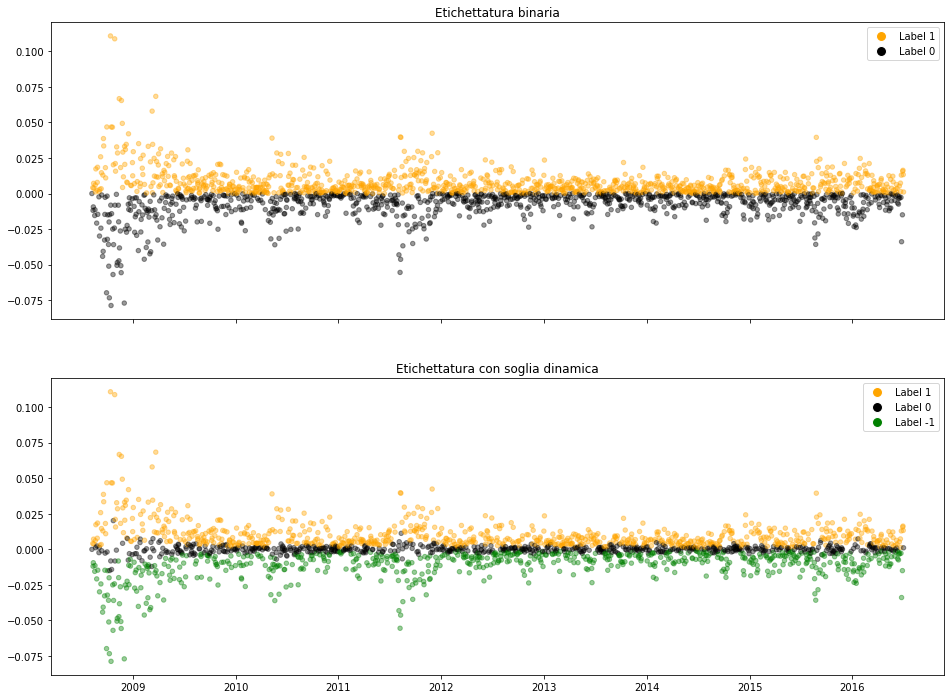

In [12]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True, figsize=(16,12))
label_colors = {1: "orange", 0: "black", -1: "green"}

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Label 1', markerfacecolor='orange', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Label 0', markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Label -1', markerfacecolor='green', markersize=10)]

ax1.scatter(stocks.index, stocks["Delta"], s=20, alpha=0.4, c=news["Label"].map(label_colors))
ax2.scatter(stocks.index, stocks["Delta"], s=20, alpha=0.4, c=news["Label2"].map(label_colors));
ax1.set_title('Etichettatura binaria')
ax2.set_title('Etichettatura con soglia dinamica')
ax1.legend(handles=legend_elements[0:2], loc="upper right")
ax2.legend(handles=legend_elements, loc="upper right")
plt.show()

## Suddivisione dati

In [13]:
news_cols = [f"Top{i}" for i in range(1, 26)]

def aggregate(l=0, a=0):
    """
    Parameters:
    ---------------------
    l: (int) shift for a (1+l) value
    a: (int) aggregate for (a) value
    ---------------------
    Returns:
    ---------------------
    one column news (data frame)
    ---------------------
    """
    
    news[news_cols] = news[news_cols].apply(lambda col: col.shift(1+l))
    news.dropna(inplace=True)

    return pd.Series([str(news[news_cols][max(0, line - a) : line + 1].values.ravel('F')) 
                         for line, _ in enumerate(news.itertuples())], name='News', index=news.index)

In [14]:
try: X
except NameError: X = aggregate(0, 0)
try: y
except NameError: y = news.Label2

In [15]:
filters = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',",",'~' , '—', 'b']

for i in range(X.size):
    for filter in filters:
        X[i] = X[i].replace(filter, '').strip()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, shuffle=False, random_state=rnd_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, shuffle=False, random_state=rnd_state)

In [17]:
tss = TimeSeriesSplit(3)

for i, (train, val) in enumerate(tss.split(X), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

FOLD 1
Training set da 2008-08-11 00:00:00 a 2010-07-30 00:00:00
Validation set da 2010-08-02 00:00:00 a 2012-07-19 00:00:00
FOLD 2
Training set da 2008-08-11 00:00:00 a 2012-07-19 00:00:00
Validation set da 2012-07-20 00:00:00 a 2014-07-14 00:00:00
FOLD 3
Training set da 2008-08-11 00:00:00 a 2014-07-14 00:00:00
Validation set da 2014-07-15 00:00:00 a 2016-07-01 00:00:00


## Classificatore casuale

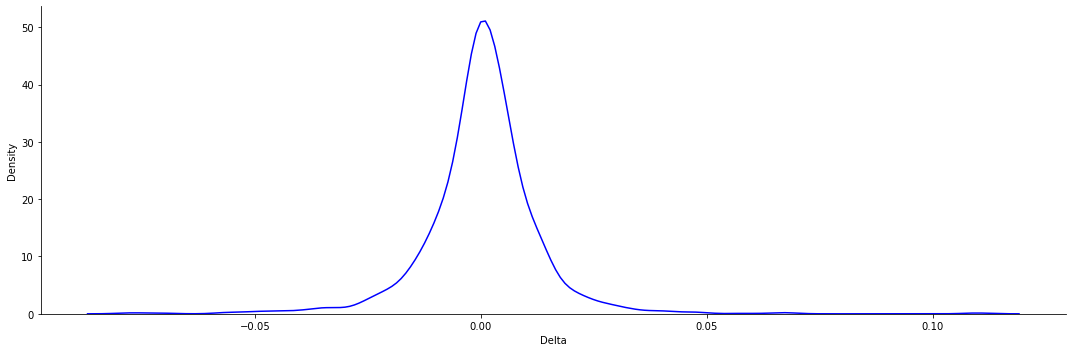

In [18]:
sns.displot(stocks["Delta"], aspect=3, kind="kde", color="blue");

In [19]:
np.random.seed(rnd_state)
random_preds = np.random.normal(y_train.mean(), y_train.std(), len(y_val))

random_preds = np.clip(list(map(lambda a : round(a), random_preds)), -1, 1)

TypeError: 'Categorical' does not implement reduction 'mean'

In [20]:
((random_preds == y_val) * 1).sum()/len(y_val)

NameError: name 'random_preds' is not defined

## NLP

In [21]:
gpu_X_train = cudf.Series.from_pandas(X_train)
gpu_y_train = cudf.Series.from_pandas(y_train)
gpu_X_test = cudf.Series.from_pandas(X_test)
gpu_y_test = cudf.Series.from_pandas(y_test)

In [ ]:
from cuml.preprocessing.text.stem import PorterStemmer
stoplist = nltk.corpus.stopwords.words("english")
stemmer = PorterStemmer()

In [ ]:
def my_scorer(y_true, y_predicted):
    error = math.sqrt(np.mean((y_true - y_predicted)**2))
    return error

In [ ]:
def my_tokenizer(text):
    return [stemmer.stem(token.lower()) for token in nltk.tokenize.word_tokenize(text) if token not in stoplist]

In [22]:
from cuml.pipeline import Pipeline
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {
    'penalty': ('l1', 'l2'),
    'C': np.linspace(1, 100, 100, endpoint=False)
}

model1 = TfidfVectorizer(min_df= 3, stop_words='english', ngram_range=(1,1))
model2 = LogisticRegression(C=10, class_weight='balanced')

gs = GridSearchCV(model2, params, cv=tss, verbose=10)

In [23]:
%%time
vect = model1.fit_transform(gpu_X_train)
gs.fit(vect.toarray(), y_train)
print(f'Migliori iperparametri: {gs.best_params_}')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START C=1.0, penalty=l1.........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 1/200] END ............C=1.0, penalty=l1;, score=nan total time=   0.5s
[CV 2/3; 1/200] START C=1.0, penalty=l1.........................................
[E] [21:45:11.958688] L-BFGS line search failed
[CV 2/3; 1/200] END ............C=1.0, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 1/200] START C=1.0, penalty=l1.........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 1/200] END ............C=1.0, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 2/200] START C=1.0, penalty=l2.........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 2/200] END ............C=1.0, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 2/200] START C=1.0, penalty=l2.........................................
[E] [21:45:12.665705] L-BFGS line search failed
[CV 2/3; 2/200] END ............C=1.0, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 2/200] START C=1.0, penalty=l2.........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 2/200] END ............C=1.0, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 3/200] START C=1.99, penalty=l1........................................
[E] [21:45:12.957873] L-BFGS line search failed
[CV 1/3; 3/200] END ...........C=1.99, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 3/200] START C=1.99, penalty=l1........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:13.202040] L-BFGS line search failed
[CV 2/3; 3/200] END ...........C=1.99, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 3/200] START C=1.99, penalty=l1........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:13.616553] L-BFGS line search failed
[CV 3/3; 3/200] END ...........C=1.99, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 4/200] START C=1.99, penalty=l2........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 4/200] END ...........C=1.99, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 4/200] START C=1.99, penalty=l2........................................
[CV 2/3; 4/200] END ...........C=1.99, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 4/200] START C=1.99, penalty=l2........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 4/200] END ...........C=1.99, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 5/200] START C=2.98, penalty=l1........................................
[CV 1/3; 5/200] END ...........C=2.98, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 5/200] START C=2.98, penalty=l1........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 5/200] END ...........C=2.98, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 5/200] START C=2.98, penalty=l1........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:14.986686] L-BFGS line search failed
[CV 3/3; 5/200] END ...........C=2.98, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 6/200] START C=2.98, penalty=l2........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 6/200] END ...........C=2.98, penalty=l2;, score=nan total time=   0.5s
[CV 2/3; 6/200] START C=2.98, penalty=l2........................................
[E] [21:45:15.590266] L-BFGS line search failed
[CV 2/3; 6/200] END ...........C=2.98, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 6/200] START C=2.98, penalty=l2........................................
[E] [21:45:15.689916] L-BFGS line search failed
[CV 3/3; 6/200] END ...........C=2.98, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 7/200] START C=3.9699999999999998, penalty=l1..........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 7/200] END C=3.9699999999999998, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 7/200] START C=3.9699999999999998, penalty=l1..........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:16.125261] L-BFGS line search failed
[CV 2/3; 7/200] END C=3.9699999999999998, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 7/200] START C=3.9699999999999998, penalty=l1..........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 7/200] END C=3.9699999999999998, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 8/200] START C=3.9699999999999998, penalty=l2..........................
[E] [21:45:16.383851] L-BFGS line search failed
[CV 1/3; 8/200] END C=3.9699999999999998, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 8/200] START C=3.9699999999999998, penalty=l2..........................
[E] [21:45:16.522917] L-BFGS line search failed
[CV 2/3; 8/200] END C=3.9699999999999998, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 8/200] START C=3.9699999999999998, penalty=l2..........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:16.946779] L-BFGS line search failed
[CV 3/3; 8/200] END C=3.9699999999999998, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 9/200] START C=4.96, penalty=l1........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 9/200] END ...........C=4.96, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 9/200] START C=4.96, penalty=l1........................................
[E] [21:45:17.228427] L-BFGS line search failed
[CV 2/3; 9/200] END ...........C=4.96, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 9/200] START C=4.96, penalty=l1........................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 9/200] END ...........C=4.96, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 10/200] START C=4.96, penalty=l2.......................................
[CV 1/3; 10/200] END ..........C=4.96, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 10/200] START C=4.96, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:17.770490] L-BFGS line search failed
[CV 2/3; 10/200] END ..........C=4.96, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 10/200] START C=4.96, penalty=l2.......................................
[E] [21:45:18.809127] L-BFGS line search failed
[CV 3/3; 10/200] END ..........C=4.96, penalty=l2;, score=nan total time=   1.0s
[CV 1/3; 11/200] START C=5.95, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 11/200] END ..........C=5.95, penalty=l1;, score=nan total time=   0.3s
[CV 2/3; 11/200] START C=5.95, penalty=l1.......................................
[CV 2/3; 11/200] END ..........C=5.95, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 11/200] START C=5.95, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 11/200] END ..........C=5.95, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 12/200] START C=5.95, penalty=l2.......................................
[CV 1/3; 12/200] END ..........C=5.95, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 12/200] START C=5.95, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:19.776730] L-BFGS line search failed
[CV 2/3; 12/200] END ..........C=5.95, penalty=l2;, score=nan total time=   0.0s
[CV 3/3; 12/200] START C=5.95, penalty=l2.......................................
[E] [21:45:20.360650] L-BFGS line search failed
[CV 3/3; 12/200] END ..........C=5.95, penalty=l2;, score=nan total time=   0.6s
[CV 1/3; 13/200] START C=6.9399999999999995, penalty=l1.........................
[CV 1/3; 13/200] END C=6.9399999999999995, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 13/200] START C=6.9399999999999995, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:20.579161] L-BFGS line search failed
[CV 2/3; 13/200] END C=6.9399999999999995, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 13/200] START C=6.9399999999999995, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 13/200] END C=6.9399999999999995, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 14/200] START C=6.9399999999999995, penalty=l2.........................
[CV 1/3; 14/200] END C=6.9399999999999995, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 14/200] START C=6.9399999999999995, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 14/200] END C=6.9399999999999995, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 14/200] START C=6.9399999999999995, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:21.556912] L-BFGS line search failed
[CV 3/3; 14/200] END C=6.9399999999999995, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 15/200] START C=7.93, penalty=l1.......................................
[E] [21:45:21.662308] L-BFGS line search failed
[CV 1/3; 15/200] END ..........C=7.93, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 15/200] START C=7.93, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 15/200] END ..........C=7.93, penalty=l1;, score=nan total time=   1.2s
[CV 3/3; 15/200] START C=7.93, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 15/200] END ..........C=7.93, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 16/200] START C=7.93, penalty=l2.......................................
[CV 1/3; 16/200] END ..........C=7.93, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 16/200] START C=7.93, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 16/200] END ..........C=7.93, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 16/200] START C=7.93, penalty=l2.......................................
[E] [21:45:23.843851] L-BFGS line search failed
[CV 3/3; 16/200] END ..........C=7.93, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 17/200] START C=8.92, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 17/200] END ..........C=8.92, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 17/200] START C=8.92, penalty=l1.......................................
[CV 2/3; 17/200] END ..........C=8.92, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 17/200] START C=8.92, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 17/200] END ..........C=8.92, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 18/200] START C=8.92, penalty=l2.......................................
[CV 1/3; 18/200] END ..........C=8.92, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 18/200] START C=8.92, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 18/200] END ..........C=8.92, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 18/200] START C=8.92, penalty=l2.......................................
[E] [21:45:25.424469] L-BFGS line search failed
[CV 3/3; 18/200] END ..........C=8.92, penalty=l2;, score=nan total time=   0.5s
[CV 1/3; 19/200] START C=9.91, penalty=l1.......................................
[E] [21:45:25.478176] L-BFGS line search failed
[CV 1/3; 19/200] END ..........C=9.91, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 19/200] START C=9.91, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 19/200] END ..........C=9.91, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 19/200] START C=9.91, penalty=l1.......................................
[E] [21:45:25.825478] L-BFGS line search failed
[CV 3/3; 19/200] END ..........C=9.91, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 20/200] START C=9.91, penalty=l2.......................................
[E] [21:45:25.877405] L-BFGS line search failed
[CV 1/3; 20/200] END ..........C=9.91, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 20/200] START C=9.91, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 20/200] END ..........C=9.91, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 20/200] START C=9.91, penalty=l2.......................................
[CV 3/3; 20/200] END ..........C=9.91, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 21/200] START C=10.9, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:26.373423] L-BFGS line search failed
[CV 1/3; 21/200] END ..........C=10.9, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 21/200] START C=10.9, penalty=l1.......................................
[E] [21:45:26.429169] L-BFGS line search failed
[CV 2/3; 21/200] END ..........C=10.9, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 21/200] START C=10.9, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 21/200] END ..........C=10.9, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 22/200] START C=10.9, penalty=l2.......................................
[CV 1/3; 22/200] END ..........C=10.9, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 22/200] START C=10.9, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:27.010527] L-BFGS line search failed
[CV 2/3; 22/200] END ..........C=10.9, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 22/200] START C=10.9, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 22/200] END ..........C=10.9, penalty=l2;, score=nan total time=   0.5s
[CV 1/3; 23/200] START C=11.89, penalty=l1......................................
[E] [21:45:27.616317] L-BFGS line search failed
[CV 1/3; 23/200] END .........C=11.89, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 23/200] START C=11.89, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:27.898600] L-BFGS line search failed
[CV 2/3; 23/200] END .........C=11.89, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 23/200] START C=11.89, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 23/200] END .........C=11.89, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 24/200] START C=11.89, penalty=l2......................................
[CV 1/3; 24/200] END .........C=11.89, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 24/200] START C=11.89, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 24/200] END .........C=11.89, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 24/200] START C=11.89, penalty=l2......................................
[CV 3/3; 24/200] END .........C=11.89, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 25/200] START C=12.879999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 25/200] END C=12.879999999999999, penalty=l1;, score=nan total time=   0.3s
[CV 2/3; 25/200] START C=12.879999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 25/200] END C=12.879999999999999, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 25/200] START C=12.879999999999999, penalty=l1.........................
[CV 3/3; 25/200] END C=12.879999999999999, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 26/200] START C=12.879999999999999, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 26/200] END C=12.879999999999999, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 26/200] START C=12.879999999999999, penalty=l2.........................
[E] [21:45:29.624589] L-BFGS line search failed
[CV 2/3; 26/200] END C=12.879999999999999, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 26/200] START C=12.879999999999999, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:30.146282] L-BFGS line search failed
[CV 3/3; 26/200] END C=12.879999999999999, penalty=l2;, score=nan total time=   0.5s
[CV 1/3; 27/200] START C=13.87, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 27/200] END .........C=13.87, penalty=l1;, score=nan total time=   0.4s
[CV 2/3; 27/200] START C=13.87, penalty=l1......................................
[CV 2/3; 27/200] END .........C=13.87, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 27/200] START C=13.87, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 27/200] END .........C=13.87, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 28/200] START C=13.87, penalty=l2......................................
[E] [21:45:31.062393] L-BFGS line search failed
[CV 1/3; 28/200] END .........C=13.87, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 28/200] START C=13.87, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:31.171528] L-BFGS line search failed
[CV 2/3; 28/200] END .........C=13.87, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 28/200] START C=13.87, penalty=l2......................................
[CV 3/3; 28/200] END .........C=13.87, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 29/200] START C=14.86, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:31.414637] L-BFGS line search failed
[CV 1/3; 29/200] END .........C=14.86, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 29/200] START C=14.86, penalty=l1......................................
[CV 2/3; 29/200] END .........C=14.86, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 29/200] START C=14.86, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:31.803137] L-BFGS line search failed
[CV 3/3; 29/200] END .........C=14.86, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 30/200] START C=14.86, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:32.033058] L-BFGS line search failed
[CV 1/3; 30/200] END .........C=14.86, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 30/200] START C=14.86, penalty=l2......................................
[CV 2/3; 30/200] END .........C=14.86, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 30/200] START C=14.86, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:32.307626] L-BFGS line search failed
[CV 3/3; 30/200] END .........C=14.86, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 31/200] START C=15.85, penalty=l1......................................
[CV 1/3; 31/200] END .........C=15.85, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 31/200] START C=15.85, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 31/200] END .........C=15.85, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 31/200] START C=15.85, penalty=l1......................................
[E] [21:45:32.740743] L-BFGS line search failed
[CV 3/3; 31/200] END .........C=15.85, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 32/200] START C=15.85, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 32/200] END .........C=15.85, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 32/200] START C=15.85, penalty=l2......................................
[CV 2/3; 32/200] END .........C=15.85, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 32/200] START C=15.85, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 32/200] END .........C=15.85, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 33/200] START C=16.84, penalty=l1......................................
[E] [21:45:33.522070] L-BFGS line search failed
[CV 1/3; 33/200] END .........C=16.84, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 33/200] START C=16.84, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 33/200] END .........C=16.84, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 33/200] START C=16.84, penalty=l1......................................
[E] [21:45:34.072261] L-BFGS line search failed
[CV 3/3; 33/200] END .........C=16.84, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 34/200] START C=16.84, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 34/200] END .........C=16.84, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 34/200] START C=16.84, penalty=l2......................................
[E] [21:45:34.335672] L-BFGS line search failed
[CV 2/3; 34/200] END .........C=16.84, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 34/200] START C=16.84, penalty=l2......................................
[E] [21:45:34.442883] L-BFGS line search failed
[CV 3/3; 34/200] END .........C=16.84, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 35/200] START C=17.83, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 35/200] END .........C=17.83, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 35/200] START C=17.83, penalty=l1......................................
[E] [21:45:34.663493] L-BFGS line search failed
[CV 2/3; 35/200] END .........C=17.83, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 35/200] START C=17.83, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 35/200] END .........C=17.83, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 36/200] START C=17.83, penalty=l2......................................
[E] [21:45:34.965512] L-BFGS line search failed
[CV 1/3; 36/200] END .........C=17.83, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 36/200] START C=17.83, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 36/200] END .........C=17.83, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 36/200] START C=17.83, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 36/200] END .........C=17.83, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 37/200] START C=18.82, penalty=l1......................................
[E] [21:45:35.668198] L-BFGS line search failed
[CV 1/3; 37/200] END .........C=18.82, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 37/200] START C=18.82, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 37/200] END .........C=18.82, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 37/200] START C=18.82, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:36.317060] L-BFGS line search failed
[CV 3/3; 37/200] END .........C=18.82, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 38/200] START C=18.82, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 38/200] END .........C=18.82, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 38/200] START C=18.82, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 38/200] END .........C=18.82, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 38/200] START C=18.82, penalty=l2......................................
[E] [21:45:37.035301] L-BFGS line search failed
[CV 3/3; 38/200] END .........C=18.82, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 39/200] START C=19.81, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 39/200] END .........C=19.81, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 39/200] START C=19.81, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:37.376580] L-BFGS line search failed
[CV 2/3; 39/200] END .........C=19.81, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 39/200] START C=19.81, penalty=l1......................................
[E] [21:45:37.759902] L-BFGS line search failed
[CV 3/3; 39/200] END .........C=19.81, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 40/200] START C=19.81, penalty=l2......................................
[CV 1/3; 40/200] END .........C=19.81, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 40/200] START C=19.81, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 40/200] END .........C=19.81, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 40/200] START C=19.81, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 40/200] END .........C=19.81, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 41/200] START C=20.8, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 41/200] END ..........C=20.8, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 41/200] START C=20.8, penalty=l1.......................................
[E] [21:45:38.642502] L-BFGS line search failed
[CV 2/3; 41/200] END ..........C=20.8, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 41/200] START C=20.8, penalty=l1.......................................
[E] [21:45:39.054157] L-BFGS line search failed
[CV 3/3; 41/200] END ..........C=20.8, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 42/200] START C=20.8, penalty=l2.......................................
[CV 1/3; 42/200] END ..........C=20.8, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 42/200] START C=20.8, penalty=l2.......................................
[E] [21:45:39.252121] L-BFGS line search failed
[CV 2/3; 42/200] END ..........C=20.8, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 42/200] START C=20.8, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:39.865764] L-BFGS line search failed
[CV 3/3; 42/200] END ..........C=20.8, penalty=l2;, score=nan total time=   0.6s
[CV 1/3; 43/200] START C=21.79, penalty=l1......................................
[CV 1/3; 43/200] END .........C=21.79, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 43/200] START C=21.79, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 43/200] END .........C=21.79, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 43/200] START C=21.79, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 43/200] END .........C=21.79, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 44/200] START C=21.79, penalty=l2......................................
[E] [21:45:40.712542] L-BFGS line search failed


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 44/200] END .........C=21.79, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 44/200] START C=21.79, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:41.040082] L-BFGS line search failed
[CV 2/3; 44/200] END .........C=21.79, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 44/200] START C=21.79, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:41.261344] L-BFGS line search failed
[CV 3/3; 44/200] END .........C=21.79, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 45/200] START C=22.78, penalty=l1......................................
[E] [21:45:41.375203] L-BFGS line search failed
[CV 1/3; 45/200] END .........C=22.78, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 45/200] START C=22.78, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 45/200] END .........C=22.78, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 45/200] START C=22.78, penalty=l1......................................
[CV 3/3; 45/200] END .........C=22.78, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 46/200] START C=22.78, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 46/200] END .........C=22.78, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 46/200] START C=22.78, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:42.088320] L-BFGS line search failed
[CV 2/3; 46/200] END .........C=22.78, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 46/200] START C=22.78, penalty=l2......................................
[E] [21:45:42.264666] L-BFGS line search failed
[CV 3/3; 46/200] END .........C=22.78, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 47/200] START C=23.77, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 47/200] END .........C=23.77, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 47/200] START C=23.77, penalty=l1......................................
[E] [21:45:42.501630] L-BFGS line search failed
[CV 2/3; 47/200] END .........C=23.77, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 47/200] START C=23.77, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:42.776003] L-BFGS line search failed
[CV 3/3; 47/200] END .........C=23.77, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 48/200] START C=23.77, penalty=l2......................................
[CV 1/3; 48/200] END .........C=23.77, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 48/200] START C=23.77, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:43.021480] L-BFGS line search failed
[CV 2/3; 48/200] END .........C=23.77, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 48/200] START C=23.77, penalty=l2......................................
[CV 3/3; 48/200] END .........C=23.77, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 49/200] START C=24.759999999999998, penalty=l1.........................
[E] [21:45:43.170710] L-BFGS error fx=0.365349 at iteration 13
[CV 1/3; 49/200] END C=24.759999999999998, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 49/200] START C=24.759999999999998, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:43.484468] L-BFGS line search failed
[CV 2/3; 49/200] END C=24.759999999999998, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 49/200] START C=24.759999999999998, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:43.770580] L-BFGS line search failed
[CV 3/3; 49/200] END C=24.759999999999998, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 50/200] START C=24.759999999999998, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:44.123936] L-BFGS line search failed
[CV 1/3; 50/200] END C=24.759999999999998, penalty=l2;, score=nan total time=   0.4s
[CV 2/3; 50/200] START C=24.759999999999998, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 50/200] END C=24.759999999999998, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 50/200] START C=24.759999999999998, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:45.080140] L-BFGS line search failed
[CV 3/3; 50/200] END C=24.759999999999998, penalty=l2;, score=nan total time=   0.7s
[CV 1/3; 51/200] START C=25.75, penalty=l1......................................
[CV 1/3; 51/200] END .........C=25.75, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 51/200] START C=25.75, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:45.468068] L-BFGS line search failed
[CV 2/3; 51/200] END .........C=25.75, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 51/200] START C=25.75, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:45.862217] L-BFGS line search failed
[CV 3/3; 51/200] END .........C=25.75, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 52/200] START C=25.75, penalty=l2......................................
[E] [21:45:46.002698] L-BFGS line search failed
[CV 1/3; 52/200] END .........C=25.75, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 52/200] START C=25.75, penalty=l2......................................
[E] [21:45:46.062522] L-BFGS line search failed
[CV 2/3; 52/200] END .........C=25.75, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 52/200] START C=25.75, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 52/200] END .........C=25.75, penalty=l2;, score=nan total time=   0.8s
[CV 1/3; 53/200] START C=26.74, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 53/200] END .........C=26.74, penalty=l1;, score=nan total time=   0.5s
[CV 2/3; 53/200] START C=26.74, penalty=l1......................................
[E] [21:45:47.556313] L-BFGS line search failed
[CV 2/3; 53/200] END .........C=26.74, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 53/200] START C=26.74, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:47.665677] L-BFGS line search failed
[CV 3/3; 53/200] END .........C=26.74, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 54/200] START C=26.74, penalty=l2......................................
[E] [21:45:47.746454] L-BFGS line search failed
[CV 1/3; 54/200] END .........C=26.74, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 54/200] START C=26.74, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 54/200] END .........C=26.74, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 54/200] START C=26.74, penalty=l2......................................
[E] [21:45:48.047595] L-BFGS line search failed
[CV 3/3; 54/200] END .........C=26.74, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 55/200] START C=27.73, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:48.250413] L-BFGS line search failed
[CV 1/3; 55/200] END .........C=27.73, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 55/200] START C=27.73, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:48.522753] L-BFGS line search failed
[CV 2/3; 55/200] END .........C=27.73, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 55/200] START C=27.73, penalty=l1......................................
[CV 3/3; 55/200] END .........C=27.73, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 56/200] START C=27.73, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:48.827040] L-BFGS line search failed
[CV 1/3; 56/200] END .........C=27.73, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 56/200] START C=27.73, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 56/200] END .........C=27.73, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 56/200] START C=27.73, penalty=l2......................................
[E] [21:45:50.041922] L-BFGS line search failed
[CV 3/3; 56/200] END .........C=27.73, penalty=l2;, score=nan total time=   0.9s
[CV 1/3; 57/200] START C=28.72, penalty=l1......................................
[E] [21:45:50.122668] L-BFGS line search failed
[CV 1/3; 57/200] END .........C=28.72, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 57/200] START C=28.72, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:50.304380] L-BFGS line search failed
[CV 2/3; 57/200] END .........C=28.72, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 57/200] START C=28.72, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:50.786214] L-BFGS line search failed
[CV 3/3; 57/200] END .........C=28.72, penalty=l1;, score=nan total time=   0.5s
[CV 1/3; 58/200] START C=28.72, penalty=l2......................................
[CV 1/3; 58/200] END .........C=28.72, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 58/200] START C=28.72, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:51.076693] L-BFGS line search failed
[CV 2/3; 58/200] END .........C=28.72, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 58/200] START C=28.72, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 58/200] END .........C=28.72, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 59/200] START C=29.71, penalty=l1......................................
[E] [21:45:51.416087] L-BFGS line search failed
[CV 1/3; 59/200] END .........C=29.71, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 59/200] START C=29.71, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:51.690088] L-BFGS line search failed
[CV 2/3; 59/200] END .........C=29.71, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 59/200] START C=29.71, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 59/200] END .........C=29.71, penalty=l1;, score=nan total time=   0.6s
[CV 1/3; 60/200] START C=29.71, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 60/200] END .........C=29.71, penalty=l2;, score=nan total time=   0.4s
[CV 2/3; 60/200] START C=29.71, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 60/200] END .........C=29.71, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 60/200] START C=29.71, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 60/200] END .........C=29.71, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 61/200] START C=30.7, penalty=l1.......................................
[E] [21:45:53.347741] L-BFGS line search failed
[CV 1/3; 61/200] END ..........C=30.7, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 61/200] START C=30.7, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:53.496909] L-BFGS line search failed
[CV 2/3; 61/200] END ..........C=30.7, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 61/200] START C=30.7, penalty=l1.......................................
[E] [21:45:53.615394] L-BFGS line search failed
[CV 3/3; 61/200] END ..........C=30.7, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 62/200] START C=30.7, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 62/200] END ..........C=30.7, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 62/200] START C=30.7, penalty=l2.......................................
[E] [21:45:53.803264] L-BFGS line search failed
[CV 2/3; 62/200] END ..........C=30.7, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 62/200] START C=30.7, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 62/200] END ..........C=30.7, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 63/200] START C=31.69, penalty=l1......................................
[CV 1/3; 63/200] END .........C=31.69, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 63/200] START C=31.69, penalty=l1......................................
[E] [21:45:54.115247] L-BFGS line search failed
[CV 2/3; 63/200] END .........C=31.69, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 63/200] START C=31.69, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 63/200] END .........C=31.69, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 64/200] START C=31.69, penalty=l2......................................
[E] [21:45:54.458758] L-BFGS line search failed
[CV 1/3; 64/200] END .........C=31.69, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 64/200] START C=31.69, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:54.544039] L-BFGS line search failed
[CV 2/3; 64/200] END .........C=31.69, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 64/200] START C=31.69, penalty=l2......................................
[CV 3/3; 64/200] END .........C=31.69, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 65/200] START C=32.68, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 65/200] END .........C=32.68, penalty=l1;, score=nan total time=   0.4s
[CV 2/3; 65/200] START C=32.68, penalty=l1......................................
[E] [21:45:55.202630] L-BFGS line search failed
[CV 2/3; 65/200] END .........C=32.68, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 65/200] START C=32.68, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:55.414197] L-BFGS line search failed
[CV 3/3; 65/200] END .........C=32.68, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 66/200] START C=32.68, penalty=l2......................................
[CV 1/3; 66/200] END .........C=32.68, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 66/200] START C=32.68, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 66/200] END .........C=32.68, penalty=l2;, score=nan total time=   0.5s
[CV 3/3; 66/200] START C=32.68, penalty=l2......................................
[E] [21:45:56.175125] L-BFGS line search failed
[CV 3/3; 66/200] END .........C=32.68, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 67/200] START C=33.67, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:56.207714] L-BFGS line search failed
[CV 1/3; 67/200] END .........C=33.67, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 67/200] START C=33.67, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 67/200] END .........C=33.67, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 67/200] START C=33.67, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 67/200] END .........C=33.67, penalty=l1;, score=nan total time=   1.0s
[CV 1/3; 68/200] START C=33.67, penalty=l2......................................
[E] [21:45:57.483123] L-BFGS line search failed
[CV 1/3; 68/200] END .........C=33.67, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 68/200] START C=33.67, penalty=l2......................................
[E] [21:45:57.556628] L-BFGS line search failed
[CV 2/3; 68/200] END .........C=33.67, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 68/200] START C=33.67, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 68/200] END .........C=33.67, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 69/200] START C=34.66, penalty=l1......................................
[E] [21:45:57.842809] L-BFGS line search failed
[CV 1/3; 69/200] END .........C=34.66, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 69/200] START C=34.66, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 69/200] END .........C=34.66, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 69/200] START C=34.66, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:58.628009] L-BFGS line search failed
[CV 3/3; 69/200] END .........C=34.66, penalty=l1;, score=nan total time=   0.5s
[CV 1/3; 70/200] START C=34.66, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 70/200] END .........C=34.66, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 70/200] START C=34.66, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 70/200] END .........C=34.66, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 70/200] START C=34.66, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 70/200] END .........C=34.66, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 71/200] START C=35.65, penalty=l1......................................
[CV 1/3; 71/200] END .........C=35.65, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 71/200] START C=35.65, penalty=l1......................................
[E] [21:45:59.583521] L-BFGS line search failed
[CV 2/3; 71/200] END .........C=35.65, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 71/200] START C=35.65, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 71/200] END .........C=35.65, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 72/200] START C=35.65, penalty=l2......................................
[CV 1/3; 72/200] END .........C=35.65, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 72/200] START C=35.65, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:45:59.999094] L-BFGS line search failed
[CV 2/3; 72/200] END .........C=35.65, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 72/200] START C=35.65, penalty=l2......................................
[CV 3/3; 72/200] END .........C=35.65, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 73/200] START C=36.64, penalty=l1......................................
[E] [21:46:00.180829] L-BFGS line search failed
[CV 1/3; 73/200] END .........C=36.64, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 73/200] START C=36.64, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 73/200] END .........C=36.64, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 73/200] START C=36.64, penalty=l1......................................
[CV 3/3; 73/200] END .........C=36.64, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 74/200] START C=36.64, penalty=l2......................................
[CV 1/3; 74/200] END .........C=36.64, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 74/200] START C=36.64, penalty=l2......................................
[E] [21:46:00.871878] L-BFGS line search failed
[CV 2/3; 74/200] END .........C=36.64, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 74/200] START C=36.64, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:01.244803] L-BFGS line search failed
[CV 3/3; 74/200] END .........C=36.64, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 75/200] START C=37.63, penalty=l1......................................
[CV 1/3; 75/200] END .........C=37.63, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 75/200] START C=37.63, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:01.457724] L-BFGS line search failed
[CV 2/3; 75/200] END .........C=37.63, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 75/200] START C=37.63, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 75/200] END .........C=37.63, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 76/200] START C=37.63, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 76/200] END .........C=37.63, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 76/200] START C=37.63, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 76/200] END .........C=37.63, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 76/200] START C=37.63, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:02.604884] L-BFGS line search failed
[CV 3/3; 76/200] END .........C=37.63, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 77/200] START C=38.62, penalty=l1......................................
[E] [21:46:02.652807] L-BFGS line search failed
[CV 1/3; 77/200] END .........C=38.62, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 77/200] START C=38.62, penalty=l1......................................
[E] [21:46:02.701782] L-BFGS line search failed
[CV 2/3; 77/200] END .........C=38.62, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 77/200] START C=38.62, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 77/200] END .........C=38.62, penalty=l1;, score=nan total time=   0.8s
[CV 1/3; 78/200] START C=38.62, penalty=l2......................................
[E] [21:46:03.631759] L-BFGS line search failed
[CV 1/3; 78/200] END .........C=38.62, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 78/200] START C=38.62, penalty=l2......................................
[E] [21:46:03.687536] L-BFGS line search failed
[CV 2/3; 78/200] END .........C=38.62, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 78/200] START C=38.62, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 78/200] END .........C=38.62, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 79/200] START C=39.61, penalty=l1......................................
[E] [21:46:03.970674] L-BFGS line search failed
[CV 1/3; 79/200] END .........C=39.61, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 79/200] START C=39.61, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:04.362450] L-BFGS line search failed
[CV 2/3; 79/200] END .........C=39.61, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 79/200] START C=39.61, penalty=l1......................................
[E] [21:46:04.512030] L-BFGS line search failed
[CV 3/3; 79/200] END .........C=39.61, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 80/200] START C=39.61, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 80/200] END .........C=39.61, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 80/200] START C=39.61, penalty=l2......................................
[CV 2/3; 80/200] END .........C=39.61, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 80/200] START C=39.61, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 80/200] END .........C=39.61, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 81/200] START C=40.6, penalty=l1.......................................
[CV 1/3; 81/200] END ..........C=40.6, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 81/200] START C=40.6, penalty=l1.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 81/200] END ..........C=40.6, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 81/200] START C=40.6, penalty=l1.......................................
[CV 3/3; 81/200] END ..........C=40.6, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 82/200] START C=40.6, penalty=l2.......................................
[E] [21:46:05.699709] L-BFGS line search failed
[CV 1/3; 82/200] END ..........C=40.6, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 82/200] START C=40.6, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:05.888396] L-BFGS line search failed
[CV 2/3; 82/200] END ..........C=40.6, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 82/200] START C=40.6, penalty=l2.......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 82/200] END ..........C=40.6, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 83/200] START C=41.589999999999996, penalty=l1.........................
[E] [21:46:06.423496] L-BFGS line search failed
[CV 1/3; 83/200] END C=41.589999999999996, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 83/200] START C=41.589999999999996, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 83/200] END C=41.589999999999996, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 83/200] START C=41.589999999999996, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 83/200] END C=41.589999999999996, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 84/200] START C=41.589999999999996, penalty=l2.........................
[CV 1/3; 84/200] END C=41.589999999999996, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 84/200] START C=41.589999999999996, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 84/200] END C=41.589999999999996, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 84/200] START C=41.589999999999996, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 84/200] END C=41.589999999999996, penalty=l2;, score=nan total time=   0.6s
[CV 1/3; 85/200] START C=42.58, penalty=l1......................................
[E] [21:46:08.040448] L-BFGS line search failed
[CV 1/3; 85/200] END .........C=42.58, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 85/200] START C=42.58, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 85/200] END .........C=42.58, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 85/200] START C=42.58, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 85/200] END .........C=42.58, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 86/200] START C=42.58, penalty=l2......................................
[E] [21:46:08.619252] L-BFGS line search failed
[CV 1/3; 86/200] END .........C=42.58, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 86/200] START C=42.58, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:08.921204] L-BFGS line search failed
[CV 2/3; 86/200] END .........C=42.58, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 86/200] START C=42.58, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 86/200] END .........C=42.58, penalty=l2;, score=nan total time=   0.6s
[CV 1/3; 87/200] START C=43.57, penalty=l1......................................
[E] [21:46:09.553145] L-BFGS line search failed
[CV 1/3; 87/200] END .........C=43.57, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 87/200] START C=43.57, penalty=l1......................................
[E] [21:46:09.595061] L-BFGS line search failed
[CV 2/3; 87/200] END .........C=43.57, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 87/200] START C=43.57, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 87/200] END .........C=43.57, penalty=l1;, score=nan total time=   0.7s
[CV 1/3; 88/200] START C=43.57, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 88/200] END .........C=43.57, penalty=l2;, score=nan total time=   0.3s
[CV 2/3; 88/200] START C=43.57, penalty=l2......................................
[E] [21:46:10.708151] L-BFGS line search failed
[CV 2/3; 88/200] END .........C=43.57, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 88/200] START C=43.57, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:10.870727] L-BFGS line search failed
[CV 3/3; 88/200] END .........C=43.57, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 89/200] START C=44.56, penalty=l1......................................
[E] [21:46:10.973312] L-BFGS line search failed
[CV 1/3; 89/200] END .........C=44.56, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 89/200] START C=44.56, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 89/200] END .........C=44.56, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 89/200] START C=44.56, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:11.453667] L-BFGS line search failed
[CV 3/3; 89/200] END .........C=44.56, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 90/200] START C=44.56, penalty=l2......................................
[CV 1/3; 90/200] END .........C=44.56, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 90/200] START C=44.56, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 90/200] END .........C=44.56, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 90/200] START C=44.56, penalty=l2......................................
[CV 3/3; 90/200] END .........C=44.56, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 91/200] START C=45.55, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 91/200] END .........C=45.55, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 91/200] START C=45.55, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:12.566830] L-BFGS line search failed
[CV 2/3; 91/200] END .........C=45.55, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 91/200] START C=45.55, penalty=l1......................................
[CV 3/3; 91/200] END .........C=45.55, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 92/200] START C=45.55, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 92/200] END .........C=45.55, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 92/200] START C=45.55, penalty=l2......................................
[E] [21:46:12.868338] L-BFGS line search failed
[CV 2/3; 92/200] END .........C=45.55, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 92/200] START C=45.55, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:13.177147] L-BFGS line search failed
[CV 3/3; 92/200] END .........C=45.55, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 93/200] START C=46.54, penalty=l1......................................
[CV 1/3; 93/200] END .........C=46.54, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 93/200] START C=46.54, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 93/200] END .........C=46.54, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 93/200] START C=46.54, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 93/200] END .........C=46.54, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 94/200] START C=46.54, penalty=l2......................................
[CV 1/3; 94/200] END .........C=46.54, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 94/200] START C=46.54, penalty=l2......................................
[E] [21:46:13.890183] L-BFGS line search failed
[CV 2/3; 94/200] END .........C=46.54, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 94/200] START C=46.54, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:13.995083] L-BFGS line search failed
[CV 3/3; 94/200] END .........C=46.54, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 95/200] START C=47.53, penalty=l1......................................
[CV 1/3; 95/200] END .........C=47.53, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 95/200] START C=47.53, penalty=l1......................................
[E] [21:46:14.180026] L-BFGS line search failed
[CV 2/3; 95/200] END .........C=47.53, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 95/200] START C=47.53, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:14.265383] L-BFGS line search failed
[CV 3/3; 95/200] END .........C=47.53, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 96/200] START C=47.53, penalty=l2......................................
[CV 1/3; 96/200] END .........C=47.53, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 96/200] START C=47.53, penalty=l2......................................
[CV 2/3; 96/200] END .........C=47.53, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 96/200] START C=47.53, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 96/200] END .........C=47.53, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 97/200] START C=48.519999999999996, penalty=l1.........................
[CV 1/3; 97/200] END C=48.519999999999996, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 97/200] START C=48.519999999999996, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 97/200] END C=48.519999999999996, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 97/200] START C=48.519999999999996, penalty=l1.........................
[E] [21:46:15.280288] L-BFGS line search failed
[CV 3/3; 97/200] END C=48.519999999999996, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 98/200] START C=48.519999999999996, penalty=l2.........................
[CV 1/3; 98/200] END C=48.519999999999996, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 98/200] START C=48.519999999999996, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:15.656469] L-BFGS line search failed
[CV 2/3; 98/200] END C=48.519999999999996, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 98/200] START C=48.519999999999996, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:15.878290] L-BFGS line search failed
[CV 3/3; 98/200] END C=48.519999999999996, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 99/200] START C=49.51, penalty=l1......................................
[E] [21:46:15.954672] L-BFGS line search failed
[CV 1/3; 99/200] END .........C=49.51, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 99/200] START C=49.51, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 99/200] END .........C=49.51, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 99/200] START C=49.51, penalty=l1......................................
[E] [21:46:16.438390] L-BFGS line search failed
[CV 3/3; 99/200] END .........C=49.51, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 100/200] START C=49.51, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:16.487362] L-BFGS line search failed
[CV 1/3; 100/200] END ........C=49.51, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 100/200] START C=49.51, penalty=l2.....................................
[E] [21:46:16.578662] L-BFGS line search failed
[CV 2/3; 100/200] END ........C=49.51, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 100/200] START C=49.51, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:16.702536] L-BFGS line search failed
[CV 3/3; 100/200] END ........C=49.51, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 101/200] START C=50.5, penalty=l1......................................
[CV 1/3; 101/200] END .........C=50.5, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 101/200] START C=50.5, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 101/200] END .........C=50.5, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 101/200] START C=50.5, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 101/200] END .........C=50.5, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 102/200] START C=50.5, penalty=l2......................................
[E] [21:46:17.374858] L-BFGS line search failed
[CV 1/3; 102/200] END .........C=50.5, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 102/200] START C=50.5, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:17.947905] L-BFGS line search failed
[CV 2/3; 102/200] END .........C=50.5, penalty=l2;, score=nan total time=   0.6s
[CV 3/3; 102/200] START C=50.5, penalty=l2......................................
[E] [21:46:18.025075] L-BFGS line search failed
[CV 3/3; 102/200] END .........C=50.5, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 103/200] START C=51.49, penalty=l1.....................................
[CV 1/3; 103/200] END ........C=51.49, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 103/200] START C=51.49, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 103/200] END ........C=51.49, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 103/200] START C=51.49, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 103/200] END ........C=51.49, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 104/200] START C=51.49, penalty=l2.....................................
[CV 1/3; 104/200] END ........C=51.49, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 104/200] START C=51.49, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:18.906621] L-BFGS line search failed
[CV 2/3; 104/200] END ........C=51.49, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 104/200] START C=51.49, penalty=l2.....................................
[CV 3/3; 104/200] END ........C=51.49, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 105/200] START C=52.48, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 105/200] END ........C=52.48, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 105/200] START C=52.48, penalty=l1.....................................
[E] [21:46:19.240558] L-BFGS line search failed
[CV 2/3; 105/200] END ........C=52.48, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 105/200] START C=52.48, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:19.330451] L-BFGS line search failed
[CV 3/3; 105/200] END ........C=52.48, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 106/200] START C=52.48, penalty=l2.....................................
[CV 1/3; 106/200] END ........C=52.48, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 106/200] START C=52.48, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 106/200] END ........C=52.48, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 106/200] START C=52.48, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 106/200] END ........C=52.48, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 107/200] START C=53.47, penalty=l1.....................................
[CV 1/3; 107/200] END ........C=53.47, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 107/200] START C=53.47, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 107/200] END ........C=53.47, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 107/200] START C=53.47, penalty=l1.....................................
[E] [21:46:20.307429] L-BFGS line search failed
[CV 3/3; 107/200] END ........C=53.47, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 108/200] START C=53.47, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 108/200] END ........C=53.47, penalty=l2;, score=nan total time=   0.4s
[CV 2/3; 108/200] START C=53.47, penalty=l2.....................................
[CV 2/3; 108/200] END ........C=53.47, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 108/200] START C=53.47, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 108/200] END ........C=53.47, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 109/200] START C=54.46, penalty=l1.....................................
[E] [21:46:21.077841] L-BFGS line search failed
[CV 1/3; 109/200] END ........C=54.46, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 109/200] START C=54.46, penalty=l1.....................................
[E] [21:46:21.164980] L-BFGS line search failed
[CV 2/3; 109/200] END ........C=54.46, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 109/200] START C=54.46, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 109/200] END ........C=54.46, penalty=l1;, score=nan total time=   0.6s
[CV 1/3; 110/200] START C=54.46, penalty=l2.....................................
[E] [21:46:21.921770] L-BFGS line search failed
[CV 1/3; 110/200] END ........C=54.46, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 110/200] START C=54.46, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:22.137639] L-BFGS line search failed
[CV 2/3; 110/200] END ........C=54.46, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 110/200] START C=54.46, penalty=l2.....................................
[E] [21:46:22.259630] L-BFGS line search failed
[CV 3/3; 110/200] END ........C=54.46, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 111/200] START C=55.45, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 111/200] END ........C=55.45, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 111/200] START C=55.45, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 111/200] END ........C=55.45, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 111/200] START C=55.45, penalty=l1.....................................
[CV 3/3; 111/200] END ........C=55.45, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 112/200] START C=55.45, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 112/200] END ........C=55.45, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 112/200] START C=55.45, penalty=l2.....................................
[CV 2/3; 112/200] END ........C=55.45, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 112/200] START C=55.45, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 112/200] END ........C=55.45, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 113/200] START C=56.44, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:23.557466] L-BFGS line search failed
[CV 1/3; 113/200] END ........C=56.44, penalty=l1;, score=nan total time=   0.3s
[CV 2/3; 113/200] START C=56.44, penalty=l1.....................................
[E] [21:46:23.687742] L-BFGS line search failed
[CV 2/3; 113/200] END ........C=56.44, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 113/200] START C=56.44, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 113/200] END ........C=56.44, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 114/200] START C=56.44, penalty=l2.....................................
[CV 1/3; 114/200] END ........C=56.44, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 114/200] START C=56.44, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 114/200] END ........C=56.44, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 114/200] START C=56.44, penalty=l2.....................................
[CV 3/3; 114/200] END ........C=56.44, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 115/200] START C=57.43, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 115/200] END ........C=57.43, penalty=l1;, score=nan total time=   0.3s
[CV 2/3; 115/200] START C=57.43, penalty=l1.....................................
[CV 2/3; 115/200] END ........C=57.43, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 115/200] START C=57.43, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 115/200] END ........C=57.43, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 116/200] START C=57.43, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 116/200] END ........C=57.43, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 116/200] START C=57.43, penalty=l2.....................................
[E] [21:46:25.227487] L-BFGS line search failed
[CV 2/3; 116/200] END ........C=57.43, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 116/200] START C=57.43, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:25.430461] L-BFGS line search failed
[CV 3/3; 116/200] END ........C=57.43, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 117/200] START C=58.42, penalty=l1.....................................
[E] [21:46:25.628519] L-BFGS line search failed
[CV 1/3; 117/200] END ........C=58.42, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 117/200] START C=58.42, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 117/200] END ........C=58.42, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 117/200] START C=58.42, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 117/200] END ........C=58.42, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 118/200] START C=58.42, penalty=l2.....................................
[CV 1/3; 118/200] END ........C=58.42, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 118/200] START C=58.42, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:26.521885] L-BFGS line search failed
[CV 2/3; 118/200] END ........C=58.42, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 118/200] START C=58.42, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 118/200] END ........C=58.42, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 119/200] START C=59.41, penalty=l1.....................................
[CV 1/3; 119/200] END ........C=59.41, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 119/200] START C=59.41, penalty=l1.....................................
[E] [21:46:26.923154] L-BFGS line search failed
[CV 2/3; 119/200] END ........C=59.41, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 119/200] START C=59.41, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 119/200] END ........C=59.41, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 120/200] START C=59.41, penalty=l2.....................................
[CV 1/3; 120/200] END ........C=59.41, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 120/200] START C=59.41, penalty=l2.....................................
[E] [21:46:27.268537] L-BFGS line search failed
[CV 2/3; 120/200] END ........C=59.41, penalty=l2;, score=nan total time=   0.0s
[CV 3/3; 120/200] START C=59.41, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 120/200] END ........C=59.41, penalty=l2;, score=nan total time=   0.5s
[CV 1/3; 121/200] START C=60.4, penalty=l1......................................
[E] [21:46:27.819521] L-BFGS line search failed
[CV 1/3; 121/200] END .........C=60.4, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 121/200] START C=60.4, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 121/200] END .........C=60.4, penalty=l1;, score=nan total time=   0.5s
[CV 3/3; 121/200] START C=60.4, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 121/200] END .........C=60.4, penalty=l1;, score=nan total time=   0.5s
[CV 1/3; 122/200] START C=60.4, penalty=l2......................................
[CV 1/3; 122/200] END .........C=60.4, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 122/200] START C=60.4, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:29.077245] L-BFGS line search failed
[CV 2/3; 122/200] END .........C=60.4, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 122/200] START C=60.4, penalty=l2......................................
[CV 3/3; 122/200] END .........C=60.4, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 123/200] START C=61.39, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:29.434692] L-BFGS line search failed
[CV 1/3; 123/200] END ........C=61.39, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 123/200] START C=61.39, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:29.661856] L-BFGS line search failed
[CV 2/3; 123/200] END ........C=61.39, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 123/200] START C=61.39, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:29.968605] L-BFGS line search failed
[CV 3/3; 123/200] END ........C=61.39, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 124/200] START C=61.39, penalty=l2.....................................
[CV 1/3; 124/200] END ........C=61.39, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 124/200] START C=61.39, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:30.246898] L-BFGS line search failed
[CV 2/3; 124/200] END ........C=61.39, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 124/200] START C=61.39, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:31.366709] L-BFGS line search failed
[CV 3/3; 124/200] END ........C=61.39, penalty=l2;, score=nan total time=   1.1s
[CV 1/3; 125/200] START C=62.38, penalty=l1.....................................
[CV 1/3; 125/200] END ........C=62.38, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 125/200] START C=62.38, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 125/200] END ........C=62.38, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 125/200] START C=62.38, penalty=l1.....................................
[E] [21:46:31.830809] L-BFGS line search failed
[CV 3/3; 125/200] END ........C=62.38, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 126/200] START C=62.38, penalty=l2.....................................
[CV 1/3; 126/200] END ........C=62.38, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 126/200] START C=62.38, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:32.043785] L-BFGS line search failed
[CV 2/3; 126/200] END ........C=62.38, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 126/200] START C=62.38, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 126/200] END ........C=62.38, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 127/200] START C=63.37, penalty=l1.....................................
[CV 1/3; 127/200] END ........C=63.37, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 127/200] START C=63.37, penalty=l1.....................................
[CV 2/3; 127/200] END ........C=63.37, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 127/200] START C=63.37, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 127/200] END ........C=63.37, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 128/200] START C=63.37, penalty=l2.....................................
[CV 1/3; 128/200] END ........C=63.37, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 128/200] START C=63.37, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:33.035190] L-BFGS line search failed
[CV 2/3; 128/200] END ........C=63.37, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 128/200] START C=63.37, penalty=l2.....................................
[E] [21:46:33.163542] L-BFGS line search failed
[CV 3/3; 128/200] END ........C=63.37, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 129/200] START C=64.36, penalty=l1.....................................
[E] [21:46:33.220151] L-BFGS line search failed
[CV 1/3; 129/200] END ........C=64.36, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 129/200] START C=64.36, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 129/200] END ........C=64.36, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 129/200] START C=64.36, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:33.807438] L-BFGS line search failed
[CV 3/3; 129/200] END ........C=64.36, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 130/200] START C=64.36, penalty=l2.....................................
[CV 1/3; 130/200] END ........C=64.36, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 130/200] START C=64.36, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 130/200] END ........C=64.36, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 130/200] START C=64.36, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 130/200] END ........C=64.36, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 131/200] START C=65.35, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 131/200] END ........C=65.35, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 131/200] START C=65.35, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 131/200] END ........C=65.35, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 131/200] START C=65.35, penalty=l1.....................................
[CV 3/3; 131/200] END ........C=65.35, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 132/200] START C=65.35, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 132/200] END ........C=65.35, penalty=l2;, score=nan total time=   0.3s
[CV 2/3; 132/200] START C=65.35, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:35.677738] L-BFGS line search failed
[CV 2/3; 132/200] END ........C=65.35, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 132/200] START C=65.35, penalty=l2.....................................
[E] [21:46:35.783622] L-BFGS line search failed
[CV 3/3; 132/200] END ........C=65.35, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 133/200] START C=66.34, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 133/200] END ........C=66.34, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 133/200] START C=66.34, penalty=l1.....................................
[CV 2/3; 133/200] END ........C=66.34, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 133/200] START C=66.34, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 133/200] END ........C=66.34, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 134/200] START C=66.34, penalty=l2.....................................
[E] [21:46:36.464061] L-BFGS line search failed
[CV 1/3; 134/200] END ........C=66.34, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 134/200] START C=66.34, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:36.623901] L-BFGS line search failed
[CV 2/3; 134/200] END ........C=66.34, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 134/200] START C=66.34, penalty=l2.....................................
[E] [21:46:36.717958] L-BFGS line search failed
[CV 3/3; 134/200] END ........C=66.34, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 135/200] START C=67.33, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 135/200] END ........C=67.33, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 135/200] START C=67.33, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 135/200] END ........C=67.33, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 135/200] START C=67.33, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 135/200] END ........C=67.33, penalty=l1;, score=nan total time=   0.5s
[CV 1/3; 136/200] START C=67.33, penalty=l2.....................................
[CV 1/3; 136/200] END ........C=67.33, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 136/200] START C=67.33, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 136/200] END ........C=67.33, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 136/200] START C=67.33, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 136/200] END ........C=67.33, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 137/200] START C=68.32, penalty=l1.....................................
[E] [21:46:38.594080] L-BFGS line search failed
[CV 1/3; 137/200] END ........C=68.32, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 137/200] START C=68.32, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 137/200] END ........C=68.32, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 137/200] START C=68.32, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 137/200] END ........C=68.32, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 138/200] START C=68.32, penalty=l2.....................................
[CV 1/3; 138/200] END ........C=68.32, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 138/200] START C=68.32, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 138/200] END ........C=68.32, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 138/200] START C=68.32, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:39.591189] L-BFGS line search failed
[CV 3/3; 138/200] END ........C=68.32, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 139/200] START C=69.31, penalty=l1.....................................
[E] [21:46:39.650564] L-BFGS line search failed
[CV 1/3; 139/200] END ........C=69.31, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 139/200] START C=69.31, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:40.113006] L-BFGS line search failed
[CV 2/3; 139/200] END ........C=69.31, penalty=l1;, score=nan total time=   0.5s
[CV 3/3; 139/200] START C=69.31, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 139/200] END ........C=69.31, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 140/200] START C=69.31, penalty=l2.....................................
[CV 1/3; 140/200] END ........C=69.31, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 140/200] START C=69.31, penalty=l2.....................................
[E] [21:46:40.506788] L-BFGS line search failed
[CV 2/3; 140/200] END ........C=69.31, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 140/200] START C=69.31, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:40.886989] L-BFGS line search failed
[CV 3/3; 140/200] END ........C=69.31, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 141/200] START C=70.3, penalty=l1......................................
[CV 1/3; 141/200] END .........C=70.3, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 141/200] START C=70.3, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 141/200] END .........C=70.3, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 141/200] START C=70.3, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 141/200] END .........C=70.3, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 142/200] START C=70.3, penalty=l2......................................
[CV 1/3; 142/200] END .........C=70.3, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 142/200] START C=70.3, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 142/200] END .........C=70.3, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 142/200] START C=70.3, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 142/200] END .........C=70.3, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 143/200] START C=71.29, penalty=l1.....................................
[CV 1/3; 143/200] END ........C=71.29, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 143/200] START C=71.29, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:42.325892] L-BFGS line search failed
[CV 2/3; 143/200] END ........C=71.29, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 143/200] START C=71.29, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:42.582267] L-BFGS line search failed
[CV 3/3; 143/200] END ........C=71.29, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 144/200] START C=71.29, penalty=l2.....................................
[E] [21:46:42.625126] L-BFGS line search failed
[CV 1/3; 144/200] END ........C=71.29, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 144/200] START C=71.29, penalty=l2.....................................
[CV 2/3; 144/200] END ........C=71.29, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 144/200] START C=71.29, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:42.860710] L-BFGS line search failed
[CV 3/3; 144/200] END ........C=71.29, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 145/200] START C=72.28, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 145/200] END ........C=72.28, penalty=l1;, score=nan total time=   0.4s
[CV 2/3; 145/200] START C=72.28, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 145/200] END ........C=72.28, penalty=l1;, score=nan total time=   0.5s
[CV 3/3; 145/200] START C=72.28, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:44.211606] L-BFGS line search failed
[CV 3/3; 145/200] END ........C=72.28, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 146/200] START C=72.28, penalty=l2.....................................
[CV 1/3; 146/200] END ........C=72.28, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 146/200] START C=72.28, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 146/200] END ........C=72.28, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 146/200] START C=72.28, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 146/200] END ........C=72.28, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 147/200] START C=73.27, penalty=l1.....................................
[CV 1/3; 147/200] END ........C=73.27, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 147/200] START C=73.27, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:45.506440] L-BFGS line search failed
[CV 2/3; 147/200] END ........C=73.27, penalty=l1;, score=nan total time=   0.6s
[CV 3/3; 147/200] START C=73.27, penalty=l1.....................................
[E] [21:46:45.675053] L-BFGS line search failed
[CV 3/3; 147/200] END ........C=73.27, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 148/200] START C=73.27, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 148/200] END ........C=73.27, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 148/200] START C=73.27, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 148/200] END ........C=73.27, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 148/200] START C=73.27, penalty=l2.....................................
[CV 3/3; 148/200] END ........C=73.27, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 149/200] START C=74.26, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 149/200] END ........C=74.26, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 149/200] START C=74.26, penalty=l1.....................................
[E] [21:46:46.455879] L-BFGS line search failed
[CV 2/3; 149/200] END ........C=74.26, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 149/200] START C=74.26, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 149/200] END ........C=74.26, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 150/200] START C=74.26, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 150/200] END ........C=74.26, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 150/200] START C=74.26, penalty=l2.....................................
[E] [21:46:47.225583] L-BFGS line search failed
[CV 2/3; 150/200] END ........C=74.26, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 150/200] START C=74.26, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:47.332862] L-BFGS line search failed
[CV 3/3; 150/200] END ........C=74.26, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 151/200] START C=75.25, penalty=l1.....................................
[E] [21:46:47.368324] L-BFGS line search failed
[CV 1/3; 151/200] END ........C=75.25, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 151/200] START C=75.25, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 151/200] END ........C=75.25, penalty=l1;, score=nan total time=   0.7s
[CV 3/3; 151/200] START C=75.25, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:48.891695] L-BFGS line search failed
[CV 3/3; 151/200] END ........C=75.25, penalty=l1;, score=nan total time=   0.8s
[CV 1/3; 152/200] START C=75.25, penalty=l2.....................................
[E] [21:46:48.955567] L-BFGS line search failed
[CV 1/3; 152/200] END ........C=75.25, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 152/200] START C=75.25, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 152/200] END ........C=75.25, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 152/200] START C=75.25, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:49.734083] L-BFGS line search failed
[CV 3/3; 152/200] END ........C=75.25, penalty=l2;, score=nan total time=   0.6s
[CV 1/3; 153/200] START C=76.24, penalty=l1.....................................
[E] [21:46:49.858973] L-BFGS line search failed
[CV 1/3; 153/200] END ........C=76.24, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 153/200] START C=76.24, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:49.946667] L-BFGS line search failed
[CV 2/3; 153/200] END ........C=76.24, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 153/200] START C=76.24, penalty=l1.....................................
[E] [21:46:50.081667] L-BFGS line search failed
[CV 3/3; 153/200] END ........C=76.24, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 154/200] START C=76.24, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:50.175347] L-BFGS line search failed
[CV 1/3; 154/200] END ........C=76.24, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 154/200] START C=76.24, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:50.545186] L-BFGS line search failed
[CV 2/3; 154/200] END ........C=76.24, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 154/200] START C=76.24, penalty=l2.....................................
[E] [21:46:50.665905] L-BFGS line search failed
[CV 3/3; 154/200] END ........C=76.24, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 155/200] START C=77.23, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:50.840438] L-BFGS line search failed
[CV 1/3; 155/200] END ........C=77.23, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 155/200] START C=77.23, penalty=l1.....................................
[E] [21:46:50.903190] L-BFGS line search failed
[CV 2/3; 155/200] END ........C=77.23, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 155/200] START C=77.23, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 155/200] END ........C=77.23, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 156/200] START C=77.23, penalty=l2.....................................
[CV 1/3; 156/200] END ........C=77.23, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 156/200] START C=77.23, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:51.499362] L-BFGS line search failed
[CV 2/3; 156/200] END ........C=77.23, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 156/200] START C=77.23, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:51.738449] L-BFGS line search failed
[CV 3/3; 156/200] END ........C=77.23, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 157/200] START C=78.22, penalty=l1.....................................
[E] [21:46:51.854823] L-BFGS line search failed
[CV 1/3; 157/200] END ........C=78.22, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 157/200] START C=78.22, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 157/200] END ........C=78.22, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 157/200] START C=78.22, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:52.602337] L-BFGS line search failed
[CV 3/3; 157/200] END ........C=78.22, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 158/200] START C=78.22, penalty=l2.....................................
[CV 1/3; 158/200] END ........C=78.22, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 158/200] START C=78.22, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 158/200] END ........C=78.22, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 158/200] START C=78.22, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 158/200] END ........C=78.22, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 159/200] START C=79.21, penalty=l1.....................................
[CV 1/3; 159/200] END ........C=79.21, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 159/200] START C=79.21, penalty=l1.....................................
[E] [21:46:53.230885] L-BFGS line search failed
[CV 2/3; 159/200] END ........C=79.21, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 159/200] START C=79.21, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:54.186509] L-BFGS line search failed
[CV 3/3; 159/200] END ........C=79.21, penalty=l1;, score=nan total time=   1.0s
[CV 1/3; 160/200] START C=79.21, penalty=l2.....................................
[E] [21:46:54.236932] L-BFGS line search failed
[CV 1/3; 160/200] END ........C=79.21, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 160/200] START C=79.21, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:54.527781] L-BFGS line search failed
[CV 2/3; 160/200] END ........C=79.21, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 160/200] START C=79.21, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 160/200] END ........C=79.21, penalty=l2;, score=nan total time=   1.1s
[CV 1/3; 161/200] START C=80.2, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 161/200] END .........C=80.2, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 161/200] START C=80.2, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:56.210146] L-BFGS line search failed
[CV 2/3; 161/200] END .........C=80.2, penalty=l1;, score=nan total time=   0.4s
[CV 3/3; 161/200] START C=80.2, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 161/200] END .........C=80.2, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 162/200] START C=80.2, penalty=l2......................................
[E] [21:46:56.711973] L-BFGS line search failed
[CV 1/3; 162/200] END .........C=80.2, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 162/200] START C=80.2, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 162/200] END .........C=80.2, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 162/200] START C=80.2, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 162/200] END .........C=80.2, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 163/200] START C=81.19, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 163/200] END ........C=81.19, penalty=l1;, score=nan total time=   0.3s
[CV 2/3; 163/200] START C=81.19, penalty=l1.....................................
[E] [21:46:57.782469] L-BFGS line search failed
[CV 2/3; 163/200] END ........C=81.19, penalty=l1;, score=nan total time=   0.0s
[CV 3/3; 163/200] START C=81.19, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 163/200] END ........C=81.19, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 164/200] START C=81.19, penalty=l2.....................................
[CV 1/3; 164/200] END ........C=81.19, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 164/200] START C=81.19, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:58.369736] L-BFGS line search failed
[CV 2/3; 164/200] END ........C=81.19, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 164/200] START C=81.19, penalty=l2.....................................
[CV 3/3; 164/200] END ........C=81.19, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 165/200] START C=82.17999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 165/200] END C=82.17999999999999, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 165/200] START C=82.17999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:46:59.401731] L-BFGS line search failed
[CV 2/3; 165/200] END C=82.17999999999999, penalty=l1;, score=nan total time=   0.6s
[CV 3/3; 165/200] START C=82.17999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 165/200] END C=82.17999999999999, penalty=l1;, score=nan total time=   0.4s
[CV 1/3; 166/200] START C=82.17999999999999, penalty=l2.........................
[E] [21:46:59.867648] L-BFGS line search failed
[CV 1/3; 166/200] END C=82.17999999999999, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 166/200] START C=82.17999999999999, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 166/200] END C=82.17999999999999, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 166/200] START C=82.17999999999999, penalty=l2.........................
[E] [21:47:00.198302] L-BFGS line search failed
[CV 3/3; 166/200] END C=82.17999999999999, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 167/200] START C=83.17, penalty=l1.....................................
[E] [21:47:00.277274] L-BFGS line search failed
[CV 1/3; 167/200] END ........C=83.17, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 167/200] START C=83.17, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:00.489102] L-BFGS line search failed
[CV 2/3; 167/200] END ........C=83.17, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 167/200] START C=83.17, penalty=l1.....................................
[CV 3/3; 167/200] END ........C=83.17, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 168/200] START C=83.17, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:00.709427] L-BFGS line search failed
[CV 1/3; 168/200] END ........C=83.17, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 168/200] START C=83.17, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:00.916486] L-BFGS line search failed
[CV 2/3; 168/200] END ........C=83.17, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 168/200] START C=83.17, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:01.183928] L-BFGS line search failed
[CV 3/3; 168/200] END ........C=83.17, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 169/200] START C=84.16, penalty=l1.....................................
[CV 1/3; 169/200] END ........C=84.16, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 169/200] START C=84.16, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:01.448215] L-BFGS line search failed
[CV 2/3; 169/200] END ........C=84.16, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 169/200] START C=84.16, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 169/200] END ........C=84.16, penalty=l1;, score=nan total time=   0.5s
[CV 1/3; 170/200] START C=84.16, penalty=l2.....................................
[CV 1/3; 170/200] END ........C=84.16, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 170/200] START C=84.16, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:02.221728] L-BFGS line search failed
[CV 2/3; 170/200] END ........C=84.16, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 170/200] START C=84.16, penalty=l2.....................................
[E] [21:47:02.381025] L-BFGS line search failed
[CV 3/3; 170/200] END ........C=84.16, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 171/200] START C=85.15, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 171/200] END ........C=85.15, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 171/200] START C=85.15, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 171/200] END ........C=85.15, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 171/200] START C=85.15, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 171/200] END ........C=85.15, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 172/200] START C=85.15, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:03.368808] L-BFGS line search failed
[CV 1/3; 172/200] END ........C=85.15, penalty=l2;, score=nan total time=   0.3s
[CV 2/3; 172/200] START C=85.15, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:03.799141] L-BFGS line search failed
[CV 2/3; 172/200] END ........C=85.15, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 172/200] START C=85.15, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:04.118560] L-BFGS line search failed
[CV 3/3; 172/200] END ........C=85.15, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 173/200] START C=86.14, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 173/200] END ........C=86.14, penalty=l1;, score=nan total time=   0.3s
[CV 2/3; 173/200] START C=86.14, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 173/200] END ........C=86.14, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 173/200] START C=86.14, penalty=l1.....................................
[CV 3/3; 173/200] END ........C=86.14, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 174/200] START C=86.14, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 174/200] END ........C=86.14, penalty=l2;, score=nan total time=   0.4s
[CV 2/3; 174/200] START C=86.14, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 174/200] END ........C=86.14, penalty=l2;, score=nan total time=   0.7s
[CV 3/3; 174/200] START C=86.14, penalty=l2.....................................
[E] [21:47:06.107180] L-BFGS line search failed
[CV 3/3; 174/200] END ........C=86.14, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 175/200] START C=87.13, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 175/200] END ........C=87.13, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 175/200] START C=87.13, penalty=l1.....................................
[E] [21:47:06.751566] L-BFGS line search failed
[CV 2/3; 175/200] END ........C=87.13, penalty=l1;, score=nan total time=   0.6s
[CV 3/3; 175/200] START C=87.13, penalty=l1.....................................
[CV 3/3; 175/200] END ........C=87.13, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 176/200] START C=87.13, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:07.010033] L-BFGS line search failed
[CV 1/3; 176/200] END ........C=87.13, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 176/200] START C=87.13, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:07.269336] L-BFGS line search failed
[CV 2/3; 176/200] END ........C=87.13, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 176/200] START C=87.13, penalty=l2.....................................
[E] [21:47:07.344367] L-BFGS line search failed
[CV 3/3; 176/200] END ........C=87.13, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 177/200] START C=88.12, penalty=l1.....................................
[E] [21:47:07.393663] L-BFGS line search failed
[CV 1/3; 177/200] END ........C=88.12, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 177/200] START C=88.12, penalty=l1.....................................
[E] [21:47:07.461078] L-BFGS line search failed
[CV 2/3; 177/200] END ........C=88.12, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 177/200] START C=88.12, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 177/200] END ........C=88.12, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 178/200] START C=88.12, penalty=l2.....................................
[E] [21:47:07.781072] L-BFGS line search failed
[CV 1/3; 178/200] END ........C=88.12, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 178/200] START C=88.12, penalty=l2.....................................
[E] [21:47:07.865593] L-BFGS line search failed
[CV 2/3; 178/200] END ........C=88.12, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 178/200] START C=88.12, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 178/200] END ........C=88.12, penalty=l2;, score=nan total time=   0.5s
[CV 1/3; 179/200] START C=89.11, penalty=l1.....................................
[CV 1/3; 179/200] END ........C=89.11, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 179/200] START C=89.11, penalty=l1.....................................
[E] [21:47:08.568410] L-BFGS line search failed
[CV 2/3; 179/200] END ........C=89.11, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 179/200] START C=89.11, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:09.567437] L-BFGS line search failed
[CV 3/3; 179/200] END ........C=89.11, penalty=l1;, score=nan total time=   1.0s
[CV 1/3; 180/200] START C=89.11, penalty=l2.....................................
[E] [21:47:09.622719] L-BFGS line search failed
[CV 1/3; 180/200] END ........C=89.11, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 180/200] START C=89.11, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 180/200] END ........C=89.11, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 180/200] START C=89.11, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 180/200] END ........C=89.11, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 181/200] START C=90.1, penalty=l1......................................
[E] [21:47:10.124063] L-BFGS line search failed
[CV 1/3; 181/200] END .........C=90.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/3; 181/200] START C=90.1, penalty=l1......................................
[CV 2/3; 181/200] END .........C=90.1, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 181/200] START C=90.1, penalty=l1......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 181/200] END .........C=90.1, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 182/200] START C=90.1, penalty=l2......................................
[CV 1/3; 182/200] END .........C=90.1, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 182/200] START C=90.1, penalty=l2......................................
[CV 2/3; 182/200] END .........C=90.1, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 182/200] START C=90.1, penalty=l2......................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:10.767764] L-BFGS line search failed
[CV 3/3; 182/200] END .........C=90.1, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 183/200] START C=91.09, penalty=l1.....................................
[CV 1/3; 183/200] END ........C=91.09, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 183/200] START C=91.09, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 183/200] END ........C=91.09, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 183/200] START C=91.09, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 183/200] END ........C=91.09, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 184/200] START C=91.09, penalty=l2.....................................
[CV 1/3; 184/200] END ........C=91.09, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 184/200] START C=91.09, penalty=l2.....................................
[E] [21:47:11.504420] L-BFGS line search failed
[CV 2/3; 184/200] END ........C=91.09, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 184/200] START C=91.09, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 184/200] END ........C=91.09, penalty=l2;, score=nan total time=   0.3s
[CV 1/3; 185/200] START C=92.08, penalty=l1.....................................
[CV 1/3; 185/200] END ........C=92.08, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 185/200] START C=92.08, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:12.025503] L-BFGS line search failed
[CV 2/3; 185/200] END ........C=92.08, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 185/200] START C=92.08, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 185/200] END ........C=92.08, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 186/200] START C=92.08, penalty=l2.....................................
[CV 1/3; 186/200] END ........C=92.08, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 186/200] START C=92.08, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:12.552941] L-BFGS line search failed
[CV 2/3; 186/200] END ........C=92.08, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 186/200] START C=92.08, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:13.270818] L-BFGS line search failed
[CV 3/3; 186/200] END ........C=92.08, penalty=l2;, score=nan total time=   0.7s
[CV 1/3; 187/200] START C=93.07, penalty=l1.....................................
[CV 1/3; 187/200] END ........C=93.07, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 187/200] START C=93.07, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 187/200] END ........C=93.07, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 187/200] START C=93.07, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 187/200] END ........C=93.07, penalty=l1;, score=nan total time=   0.7s
[CV 1/3; 188/200] START C=93.07, penalty=l2.....................................
[CV 1/3; 188/200] END ........C=93.07, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 188/200] START C=93.07, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 188/200] END ........C=93.07, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 188/200] START C=93.07, penalty=l2.....................................
[E] [21:47:14.928961] L-BFGS line search failed
[CV 3/3; 188/200] END ........C=93.07, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 189/200] START C=94.06, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 189/200] END ........C=94.06, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 189/200] START C=94.06, penalty=l1.....................................
[CV 2/3; 189/200] END ........C=94.06, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 189/200] START C=94.06, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:15.438888] L-BFGS line search failed
[CV 3/3; 189/200] END ........C=94.06, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 190/200] START C=94.06, penalty=l2.....................................
[E] [21:47:15.491555] L-BFGS line search failed
[CV 1/3; 190/200] END ........C=94.06, penalty=l2;, score=nan total time=   0.0s
[CV 2/3; 190/200] START C=94.06, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 190/200] END ........C=94.06, penalty=l2;, score=nan total time=   0.3s
[CV 3/3; 190/200] START C=94.06, penalty=l2.....................................
[E] [21:47:15.900982] L-BFGS line search failed
[CV 3/3; 190/200] END ........C=94.06, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 191/200] START C=95.05, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 191/200] END ........C=95.05, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 191/200] START C=95.05, penalty=l1.....................................
[E] [21:47:16.203242] L-BFGS line search failed
[CV 2/3; 191/200] END ........C=95.05, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 191/200] START C=95.05, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 191/200] END ........C=95.05, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 192/200] START C=95.05, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:16.564408] L-BFGS line search failed
[CV 1/3; 192/200] END ........C=95.05, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 192/200] START C=95.05, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 192/200] END ........C=95.05, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 192/200] START C=95.05, penalty=l2.....................................
[E] [21:47:16.887295] L-BFGS line search failed
[CV 3/3; 192/200] END ........C=95.05, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 193/200] START C=96.03999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:17.012937] L-BFGS line search failed
[CV 1/3; 193/200] END C=96.03999999999999, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 193/200] START C=96.03999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 193/200] END C=96.03999999999999, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 193/200] START C=96.03999999999999, penalty=l1.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 193/200] END C=96.03999999999999, penalty=l1;, score=nan total time=   0.2s
[CV 1/3; 194/200] START C=96.03999999999999, penalty=l2.........................
[CV 1/3; 194/200] END C=96.03999999999999, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 194/200] START C=96.03999999999999, penalty=l2.........................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 194/200] END C=96.03999999999999, penalty=l2;, score=nan total time=   0.4s
[CV 3/3; 194/200] START C=96.03999999999999, penalty=l2.........................
[CV 3/3; 194/200] END C=96.03999999999999, penalty=l2;, score=nan total time=   0.1s
[CV 1/3; 195/200] START C=97.03, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:18.313578] L-BFGS line search failed
[CV 1/3; 195/200] END ........C=97.03, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 195/200] START C=97.03, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 195/200] END ........C=97.03, penalty=l1;, score=nan total time=   0.2s
[CV 3/3; 195/200] START C=97.03, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 195/200] END ........C=97.03, penalty=l1;, score=nan total time=   1.0s
[CV 1/3; 196/200] START C=97.03, penalty=l2.....................................
[E] [21:47:19.576979] L-BFGS line search failed
[CV 1/3; 196/200] END ........C=97.03, penalty=l2;, score=nan total time=   0.1s
[CV 2/3; 196/200] START C=97.03, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 196/200] END ........C=97.03, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 196/200] START C=97.03, penalty=l2.....................................
[E] [21:47:19.926647] L-BFGS line search failed
[CV 3/3; 196/200] END ........C=97.03, penalty=l2;, score=nan total time=   0.2s
[CV 1/3; 197/200] START C=98.02, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 197/200] END ........C=98.02, penalty=l1;, score=nan total time=   0.2s
[CV 2/3; 197/200] START C=98.02, penalty=l1.....................................
[CV 2/3; 197/200] END ........C=98.02, penalty=l1;, score=nan total time=   0.1s
[CV 3/3; 197/200] START C=98.02, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 197/200] END ........C=98.02, penalty=l1;, score=nan total time=   0.3s
[CV 1/3; 198/200] START C=98.02, penalty=l2.....................................
[CV 1/3; 198/200] END ........C=98.02, penalty=l2;, score=nan total time=   0.2s
[CV 2/3; 198/200] START C=98.02, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 198/200] END ........C=98.02, penalty=l2;, score=nan total time=   0.1s
[CV 3/3; 198/200] START C=98.02, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 198/200] END ........C=98.02, penalty=l2;, score=nan total time=   0.4s
[CV 1/3; 199/200] START C=99.01, penalty=l1.....................................
[E] [21:47:21.395762] L-BFGS line search failed
[CV 1/3; 199/200] END ........C=99.01, penalty=l1;, score=nan total time=   0.1s
[CV 2/3; 199/200] START C=99.01, penalty=l1.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[E] [21:47:21.657875] L-BFGS line search failed
[CV 2/3; 199/200] END ........C=99.01, penalty=l1;, score=nan total time=   0.3s
[CV 3/3; 199/200] START C=99.01, penalty=l1.....................................
[CV 3/3; 199/200] END ........C=99.01, penalty=l1;, score=nan total time=   0.1s
[CV 1/3; 200/200] START C=99.01, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 1/3; 200/200] END ........C=99.01, penalty=l2;, score=nan total time=   0.3s
[CV 2/3; 200/200] START C=99.01, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 2/3; 200/200] END ........C=99.01, penalty=l2;, score=nan total time=   0.2s
[CV 3/3; 200/200] START C=99.01, penalty=l2.....................................


/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/internals/api_decorators.py", line 415, in inner
    return func(*args, **kwargs)
  File "/home/diaclo/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/cuml/common/mixins.py", line 254, in score
    return accuracy_score(y, preds, handle=handle)
  File "/home/diaclo/anaconda3

[CV 3/3; 200/200] END ........C=99.01, penalty=l2;, score=nan total time=   0.3s
Migliori iperparametri: {'C': 1.0, 'penalty': 'l1'}
CPU times: user 2min 11s, sys: 1.15 s, total: 2min 12s
Wall time: 2min 12s


In [24]:
vect2 = model1.transform(gpu_X_test)

In [25]:
gs.score(vect2.toarray(), gpu_y_test)

ValueError: value not found

In [ ]:
from cuml.metrics import confusion_matrix
y_pred = gs.predict(vect2.toarray())
cf_matrix = confusion_matrix(y_val, y_pred)

In [ ]:
cf_matrix

In [ ]:
y_pred_prob = gs.predict_proba(vect2.toarray())

In [ ]:
predicted_true = np.where(y_pred_prob > 0.70)[0]

In [ ]:
print(f"istanze train: {y_train.size}, istanze val: {y_val.size}, istanze prob 0.70: {predicted_true.size}")

In [ ]:
print(f"l''algoritmo di classificazione predice con sicurezza: {(y_pred[predicted_true] == gpu_y_test.iloc[predicted_true]).sum()/predicted_true.size}")

In [ ]:
gpu_y_test.iloc[predicted_true]